## 투빅스 18기 Time series 과제 - 18기 이다인

### Electric_Production.csv 데이터를 활용하여 자유롭게 시계열분석을 진행해주세요.
첨부한 '시계열자료_실습.ipynb' 코드를 참고하셔도 좋습니다.
데이터셋 출처 :  https://www.kaggle.com/datasets/shenba/time-series-datasets

### Box-Jenkins 방법론
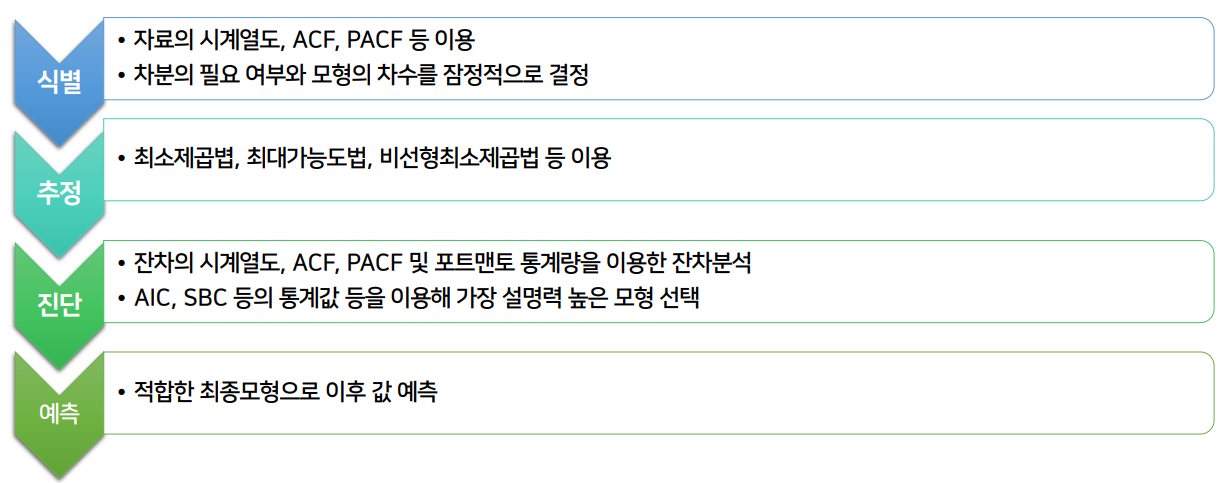
대략적 흐름 예시를 확인하고 싶다면 첨부한 '시계열자료_참고자료.pdf'를 읽어주세요.

### Prophet
튜토리얼 : https://hyperconnect.github.io/2020/03/09/prophet-package.html

## 라이브러리 불러오기

In [66]:
#패키지 import
import numpy as np
import pandas as pd
import datetime
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

#모델 패키지 import
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.tsa.stattools import adfuller

#auro arima 모델 import
import pmdarima as pm

## 데이터 불러오기

In [2]:
df = pd.read_csv('./Electric_Production.csv')
df.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DATE        397 non-null    object 
 1   IPG2211A2N  397 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


* 결측치는 없는 것으로 보인다.

In [4]:
df.rename(columns={'IPG2211A2N':'Electric_Production', 'DATE':'Month'}, inplace=True)

In [5]:
df.Month = pd.to_datetime(df.Month)

In [6]:
df = df.set_index("Month")
df.head()

,Electric_Production
Month,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


* 이번 과제의 데이터는 월 별로 전기 생산량을 나타낸 데이터이다.

## 1. 데이터의 Stationarity check

* 데이터의 특성에 따라 정확도와 효율이 높은 모델이 달라지기 때문에 예측 모델의 구현은 시계열 데이터의 특성을 확인하는 것에서 시작해야 한다.

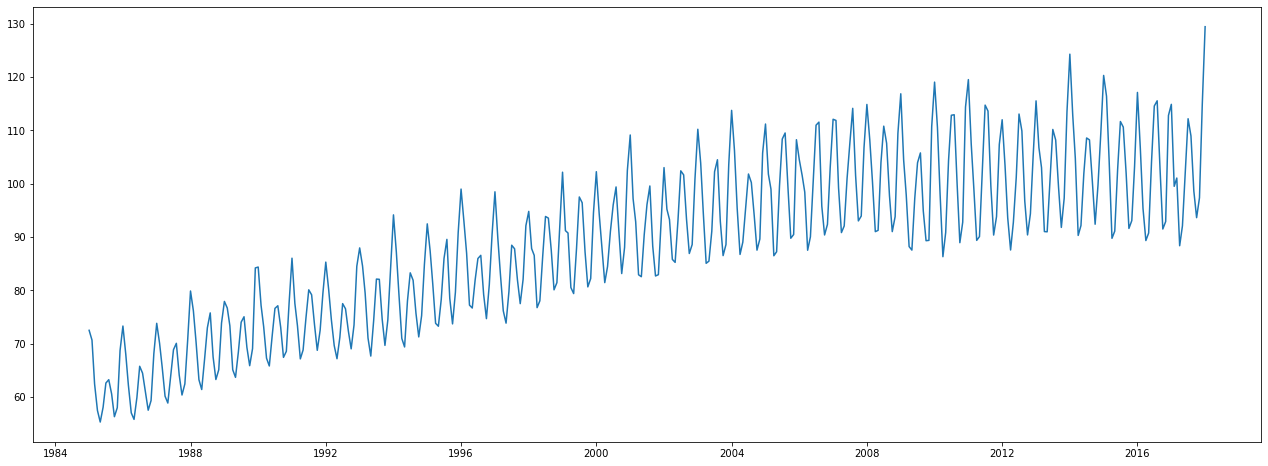

In [7]:
plt.figure(figsize=(22,8))
plt.plot(df.index, df["Electric_Production"], linestyle="-")
plt.xlabel=('Month')
plt.ylabel=('Electric_Production')
plt.show()

<Figure size 432x288 with 0 Axes>

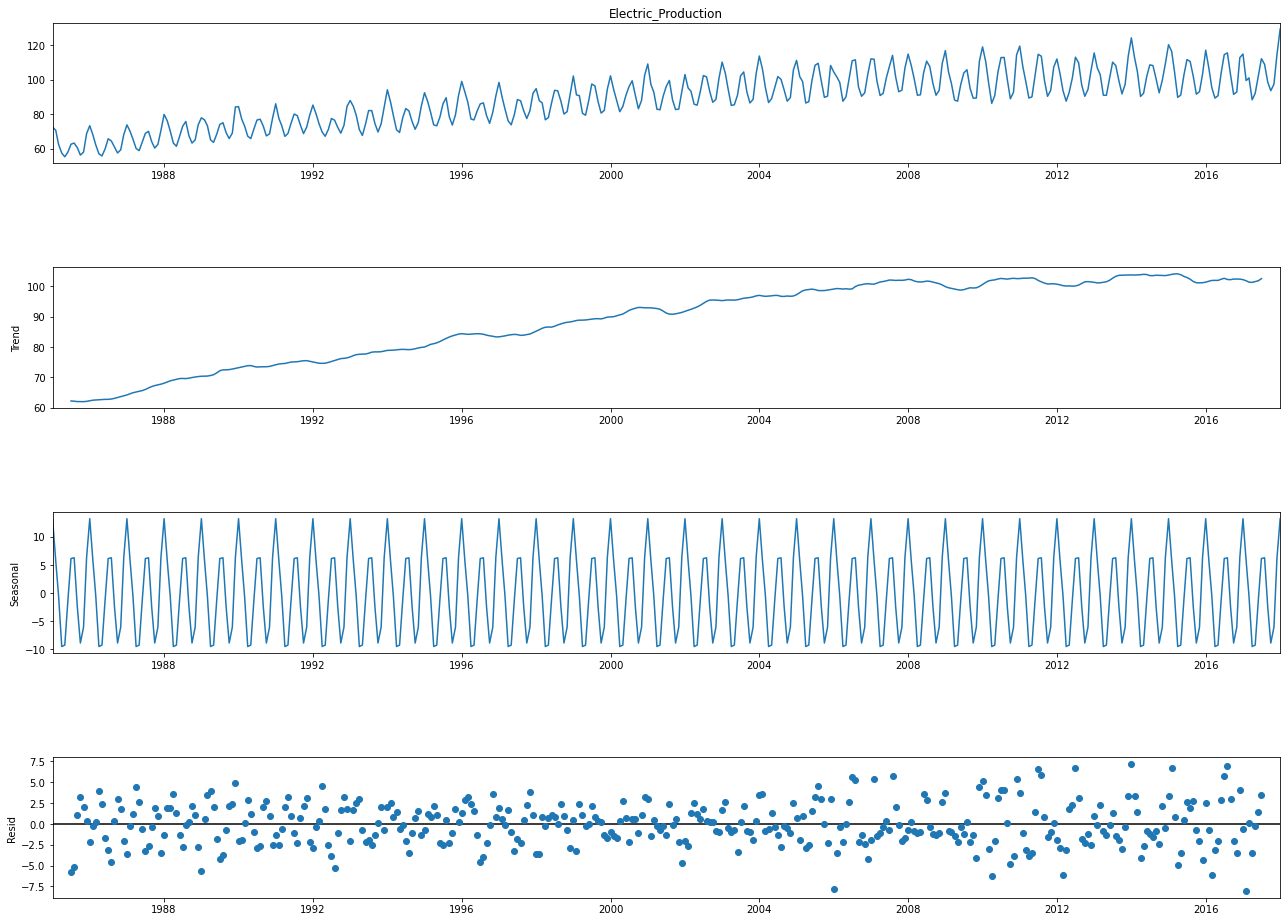

In [8]:
a = seasonal_decompose(df["Electric_Production"], model = "add")
fig = plt.figure()
fig = a.plot()
fig.set_size_inches(20,15)

<Figure size 432x288 with 0 Axes>

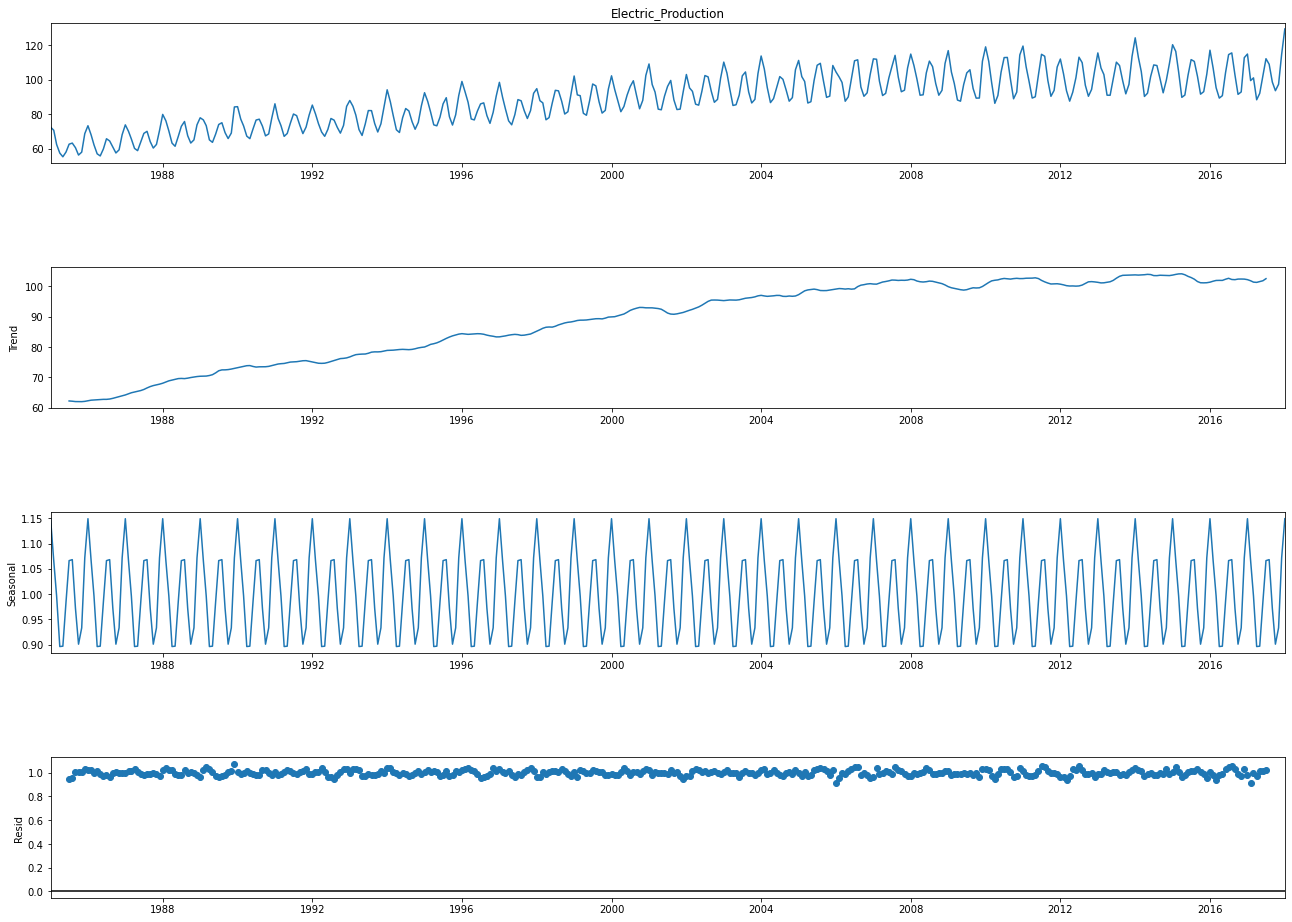

In [9]:
a = seasonal_decompose(df["Electric_Production"], model = "multiplicative")
fig = plt.figure()
fig = a.plot()
fig.set_size_inches(20,15)

* 위 데이터는 시간이 흐름에 따라 측정값이 우상향 한 다는 것을 알 수 있고, 주기적으로 유사한 패턴이 반복되고 있음을 알 수 있다.
* 또한 데이터의 변동폭이 일정하지 않은 것을 통해 데이터가 정상성을 띄지 않는다고 생각하였다. -> 로그 변환
* 시계열 그래프를 분석해본 결과 가법적 분해가 승법적 분해보다 잔차도가 더 적합한 것을 알 수 있다. 선을 기준으로 잔차의 값들이 비교적 고르게 분포하고 있기 때문이다.

**ACF**  
-자기상관함수로 시차에 따른 일련의 자기상관을 의미한다.  
-시차가 커질수록 ACF는 0에 가까워진다.   

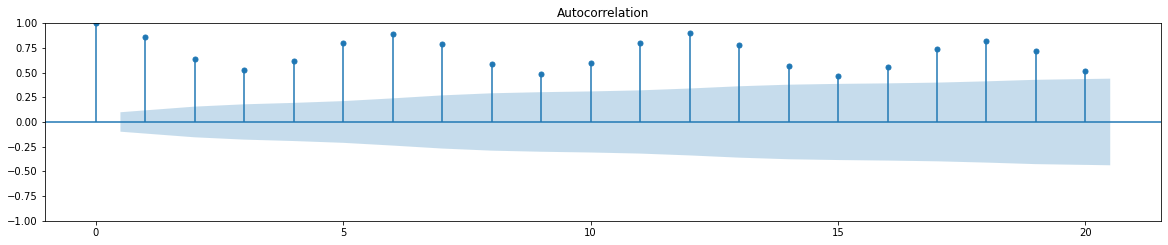

In [10]:
#ACF
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df, lags=20, ax=ax1)

* ACF그래프를 확인해 본 결과 ACF가 아주 느리게 감소하는 것을 볼 수 있다.
* ADF검정을 통해서 한 번더 데이터의 정상성을 확인해보려고 한다.

**ADF 검정**  
-H0(귀무가설) : 자료가 정상성을 만족하지 못한다.  
-H1(대립가설) : 자료가 정상성을 만족한다.  
*p-value 값이 0.05를 넘으면 귀무가설이라 판단하고 해당 데이터가 정상성을 만족하지 못한다고 판단한다.*

In [11]:
result = adfuller(df)
print('ADF Statistic %f' %result[0])
print('p-value: %f' %result[1])

ADF Statistic -2.256990
p-value: 0.186215


* p-value 값이 0.05를 훨씬 넘는 것을 보아 데이터는 정상성을 띄지 않는다고 판단할 수 있다. 따라서 차분을 진행해보려 한다.
* 또한 데이터의 변동폭이 일정하지 않으므로 로그 변환을 진행해보려 한다.

**Log 변환**

Text(0.5, 1.0, 'Log transform')

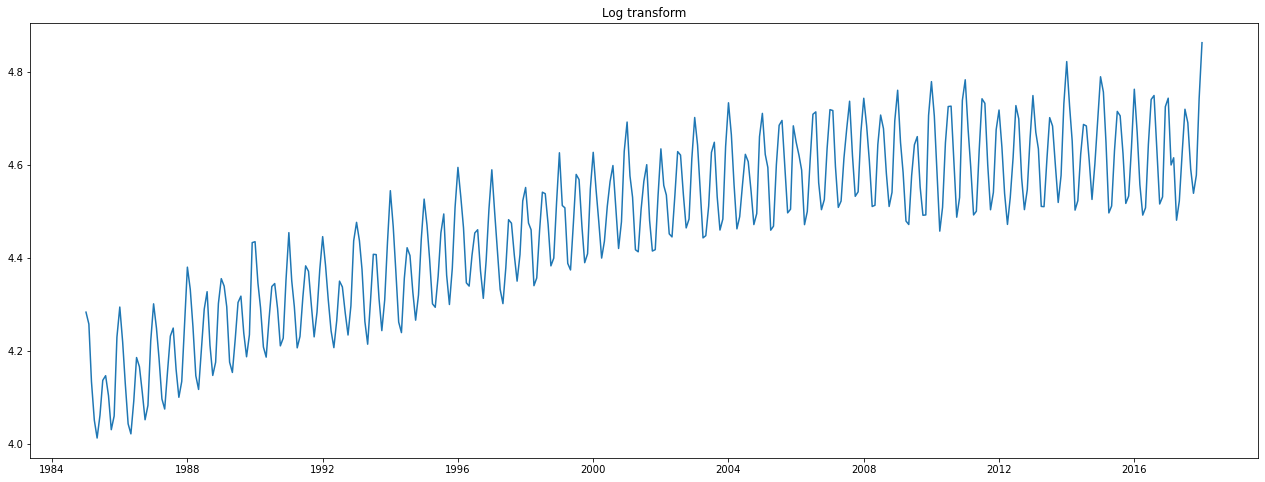

In [18]:
df_log = np.log(df)
plt.figure(figsize=(22,8))
plt.plot(df_log)
plt.title('Log transform')

* 로그 변환 후 변동폭이 일정해진 것을 확인할 수 있다.

**1차 차분 진행**

Text(0.5, 1.0, 'Differencing method')

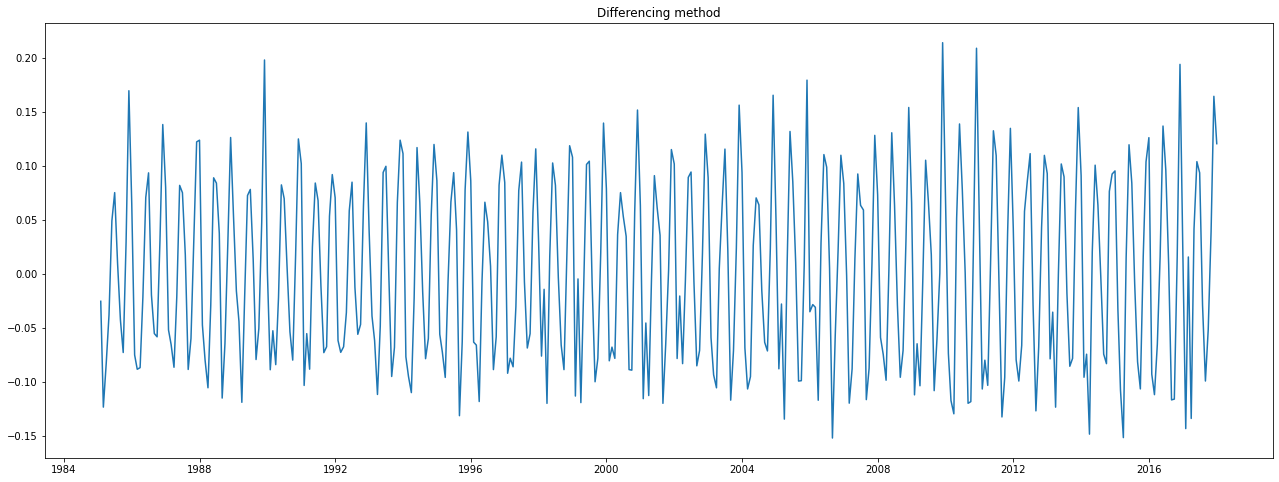

In [19]:
df_log_diff = df_log - df_log.shift()
plt.figure(figsize=(22,8))
plt.plot(df_log_diff)
plt.title('Differencing method')

* 로그 변환과 1차 차분을 진행한 후 변동폭과 평균이 모두 일정한 시계열로 변화된 것을 확인할 수 있다.

In [25]:
result = adfuller(df_log_diff[1:])
print('ADF Statistic %f' %result[0])
print('p-value: %f' %result[1])

ADF Statistic -6.748333
p-value: 0.000000


* p-value 값이 0.05보다 작으므로 로그 변환과 1차차분을 진행한 데이터는 정상성을 만족한다고 판단할 수 있다.
* 이제 정상성을 만족하는 데이터가 되었으므로, ACF, PACF를 그려보고 ARIMA 모형의 p,q를 추정해보려고 한다.

## 2. ARIMA

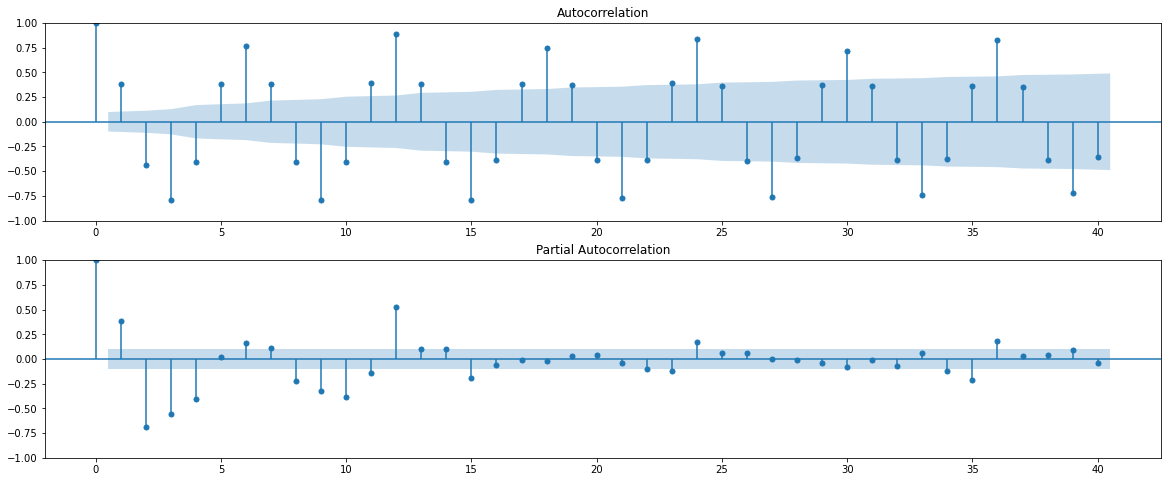

In [31]:
#ACF
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_log_diff[1:], lags=40, ax=ax1)
#PACF
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_log_diff[1:], lags=40, ax=ax2)

* ACF그래프는 점차적으로 감소한다고 볼 수 있고, PACF 그래프 또한 점차 감소하는 것으로 볼 수 있다.
* ACF그래프와 PACF 그래프 모두 0에 수렴하는 확실한 지점을 찾기 어렵기 때문에 가장 큰 lag값을 토대로 모형을 파악해보려고 한다. ACF그래프는 3의 지점이 가장 큰 값을 가지기 때문에 MA(3)으로 설정해보려고 하며, PACF그래프는 2에서 가장 큰 값을 가지기 때문에 AR(2)로 설정해보려고 한다.
* PACF 그래프에서 lag가 5인 지점에서 파란상자 안에 위치하는 것을 확인할 수 있다. 따라서 AR(4)모형도 고려해보기로 하였다.
* 차분을 한 번 더 진행하면 더 좋은 모형을 파악할 수 있을까 싶어 한 번 더 진행해보았다.

Text(0.5, 1.0, 'Differencing method2')

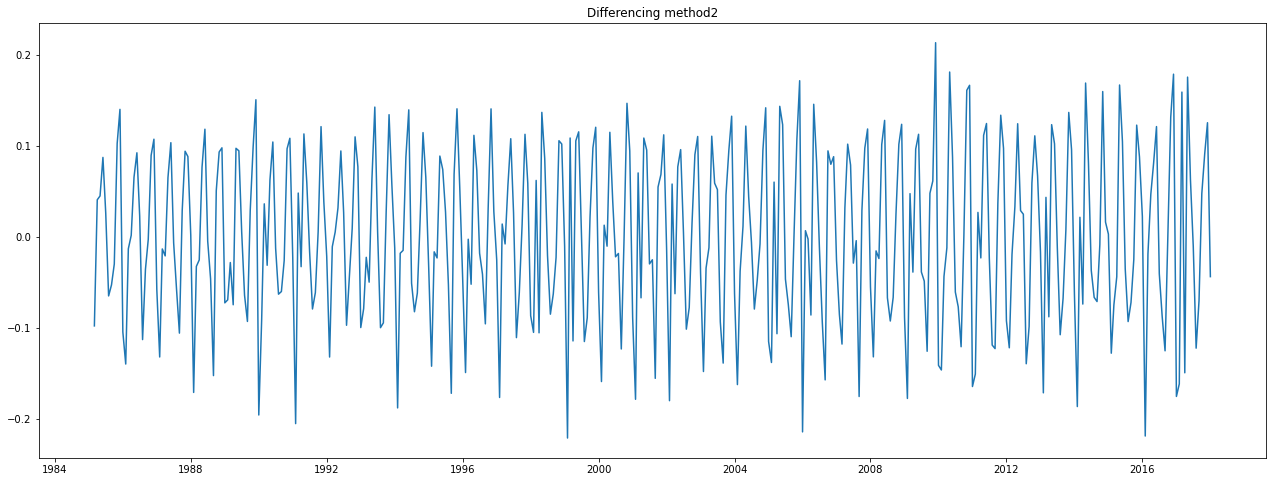

In [34]:
df_log_diff2 = df_log_diff.diff().dropna()
plt.figure(figsize=(22,8))
plt.plot(df_log_diff2)
plt.title('Differencing method2')

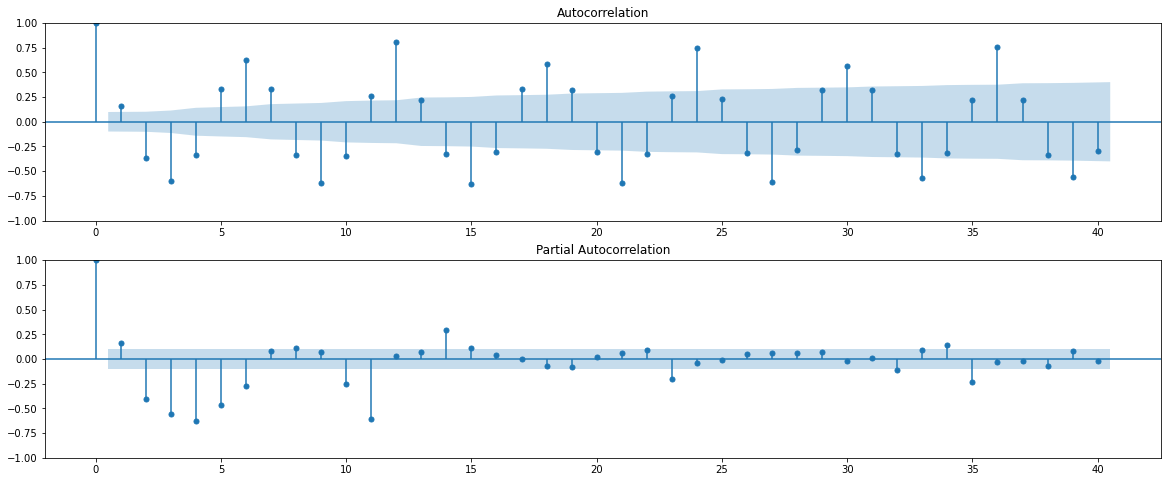

In [35]:
#ACF
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_log_diff2[1:], lags=40, ax=ax1)
#PACF
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_log_diff2[1:], lags=40, ax=ax2)

* 차분을 진행해본 결과 모형 파악에는 큰 의미가 없는 것을 보여 1차차분한 그래프를 통해 잠정모형을 파악해보았다.

**ARIMA 잠정 모형**
1. ARIMA(4,1,0)
2. ARIMA(2,1,3)
3. ARIMA(2,1,2)
4. ARIMA(2,1,1)
5. ARIMA(2,1,0)
6. ARIMA(0,1,3)

In [38]:
data = df_log_diff[1:]
train_data = data[:len(data)-12]
test_data = data[len(data)-12:]

In [40]:
train_data.head()

,Electric_Production
Month,
1985-02-01,-0.025609
1985-03-01,-0.123680
1985-04-01,-0.083082
1985-05-01,-0.038242
1985-06-01,0.048954


In [52]:
model1 = ARIMA(train_data.Electric_Production, order=(4,1,0))
model1_fit = model1.fit()
print(model1_fit.summary())

                                SARIMAX Results                                
Dep. Variable:     Electric_Production   No. Observations:                  384
Model:                  ARIMA(4, 1, 0)   Log Likelihood                 580.953
Date:                 Mon, 22 Aug 2022   AIC                          -1151.907
Time:                         15:28:19   BIC                          -1132.166
Sample:                     02-01-1985   HQIC                         -1144.076
                          - 01-01-2017                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3408      0.037     -9.117      0.000      -0.414      -0.268
ar.L2         -0.4526      0.033    -13.740      0.000      -0.517      -0.388
ar.L3         -0.5631      0.036    -15.709 

* 실행결과를 분석해보았을 때 모든 계수의 p-value가 0.05이하로 나타나는 것을 확인할 수 있다. 따라서 이는 유의미한 값이라는 것을 알 수 있다.

In [53]:
model2 = ARIMA(train_data.Electric_Production, order=(2,1,3))
model2_fit = model2.fit()
print(model2_fit.summary())

                                SARIMAX Results                                
Dep. Variable:     Electric_Production   No. Observations:                  384
Model:                  ARIMA(2, 1, 3)   Log Likelihood                 731.113
Date:                 Mon, 22 Aug 2022   AIC                          -1450.227
Time:                         15:30:28   BIC                          -1426.539
Sample:                     02-01-1985   HQIC                         -1440.830
                          - 01-01-2017                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.002    567.452      0.000       0.996       1.003
ar.L2         -0.9994      0.001  -1028.224      0.000      -1.001      -0.998
ma.L1         -2.0659     67.486     -0.031 

* 실행결과를 분석해보았을 때 ar의 경우 p-value가 0.05이하로 나타나지만, ma의 경우 p-value값이 0.05이상인 부분이 많은 것을 확인할 수 있다. 따라서 ma를 3으로 설정하는 것은 옳지 않다고 볼 수 있다.
* 잠정 모형중 ma가 3인 모형은 더 이상 확인해보지 않기로 하였다.

In [59]:
model3 = ARIMA(train_data.Electric_Production, order=(2,1,2))
model3_fit = model3.fit()
print(model3_fit.summary())

                                SARIMAX Results                                
Dep. Variable:     Electric_Production   No. Observations:                  384
Model:                  ARIMA(2, 1, 2)   Log Likelihood                 670.955
Date:                 Mon, 22 Aug 2022   AIC                          -1331.910
Time:                         15:36:41   BIC                          -1312.170
Sample:                     02-01-1985   HQIC                         -1324.080
                          - 01-01-2017                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9433      0.033     28.352      0.000       0.878       1.009
ar.L2         -0.8401      0.027    -30.856      0.000      -0.894      -0.787
ma.L1         -1.9366      0.019   -100.861 

* 실행결과를 분석해보았을 때 모든 계수의 p-value가 0.05이하로 나타나는 것을 확인할 수 있다. 따라서 이는 유의미한 값이라는 것을 알 수 있다.

In [60]:
model4 = ARIMA(train_data.Electric_Production, order=(2,1,1))
model4_fit = model4.fit()
print(model4_fit.summary())

                                SARIMAX Results                                
Dep. Variable:     Electric_Production   No. Observations:                  384
Model:                  ARIMA(2, 1, 1)   Log Likelihood                 563.942
Date:                 Mon, 22 Aug 2022   AIC                          -1119.884
Time:                         15:36:49   BIC                          -1104.092
Sample:                     02-01-1985   HQIC                         -1113.619
                          - 01-01-2017                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6635      0.038     17.442      0.000       0.589       0.738
ar.L2         -0.7048      0.039    -17.901      0.000      -0.782      -0.628
ma.L1         -0.9998      1.196     -0.836 

* 실행결과를 분석해보았을 때 ar의 경우 p-value가 0.05이하로 나타나지만, ma의 경우 p-value값이 0.05이상인 부분이 많은 것을 확인할 수 있다. 따라서 ma를 1로 설정하는 것은 옳지 않다고 볼 수 있다.

In [61]:
model5 = ARIMA(train_data.Electric_Production, order=(2,1,0))
model5_fit = model5.fit()
print(model5_fit.summary())

                                SARIMAX Results                                
Dep. Variable:     Electric_Production   No. Observations:                  384
Model:                  ARIMA(2, 1, 0)   Log Likelihood                 413.066
Date:                 Mon, 22 Aug 2022   AIC                           -820.132
Time:                         15:37:33   BIC                           -808.288
Sample:                     02-01-1985   HQIC                          -815.434
                          - 01-01-2017                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2603      0.050      5.185      0.000       0.162       0.359
ar.L2         -0.4337      0.046     -9.334      0.000      -0.525      -0.343
sigma2         0.0068      0.001     11.853 

* 실행결과를 분석해보았을 때 모든 계수의 p-value가 0.05이하로 나타나는 것을 확인할 수 있다. 따라서 이는 유의미한 값이라는 것을 알 수 있다.

**유의미한 잠정 모형**
1. ARIMA(4,1,0) : model1
2. ARIMA(2,1,2) : model3
3. ARIMA(2,1,0) : model5

* 유의미한 잠정 모형을 위의 3개로 추려볼 수 있었고, 잔차분석을 통해 최종모형을 선택해볼 예정이다.

**잔차분석**

Text(0.5, 1.0, 'model5 ADF')

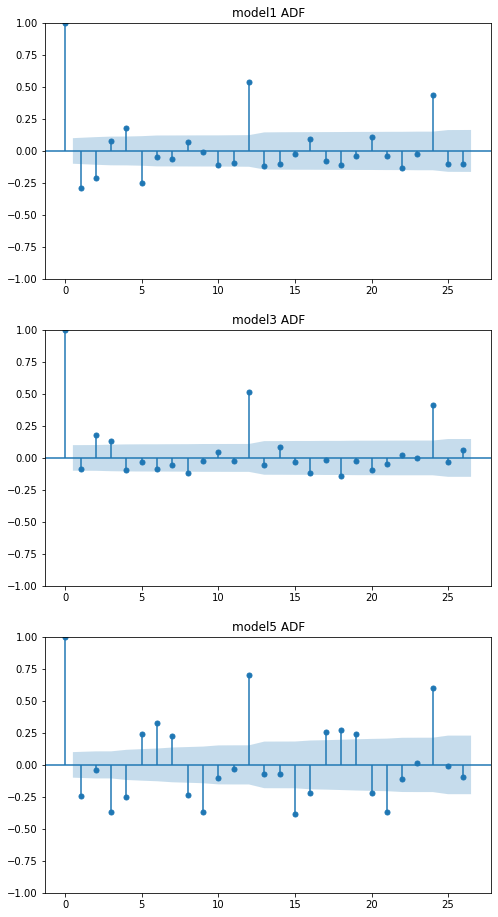

In [85]:
#잔차의 ACF확인
fig = plt.figure(figsize=(8,16))
#model1 ACF
ax1 = fig.add_subplot(311)
fig = sm.graphics.tsa.plot_acf(model1_fit.resid, ax=ax1)
plt.title('model1 ADF')
#model3 ACF
ax2 = fig.add_subplot(312)
fig = sm.graphics.tsa.plot_acf(model3_fit.resid, ax=ax2)
plt.title('model3 ADF')
#model5 ACF
ax3 = fig.add_subplot(313)
fig = sm.graphics.tsa.plot_acf(model5_fit.resid, ax=ax3)
plt.title('model5 ADF')

* 잔차가 백색 잡음을 따르는지를 확인하기 위해 잔차에 대한 ACF를 확인해본 결과 model3, 즉 ARIMA(2,1,2)일 때가 가장 백색 잡음과 가까운 잔차를 보이는 것을 알 수 있다.

Text(0.5, 1.0, 'model5')

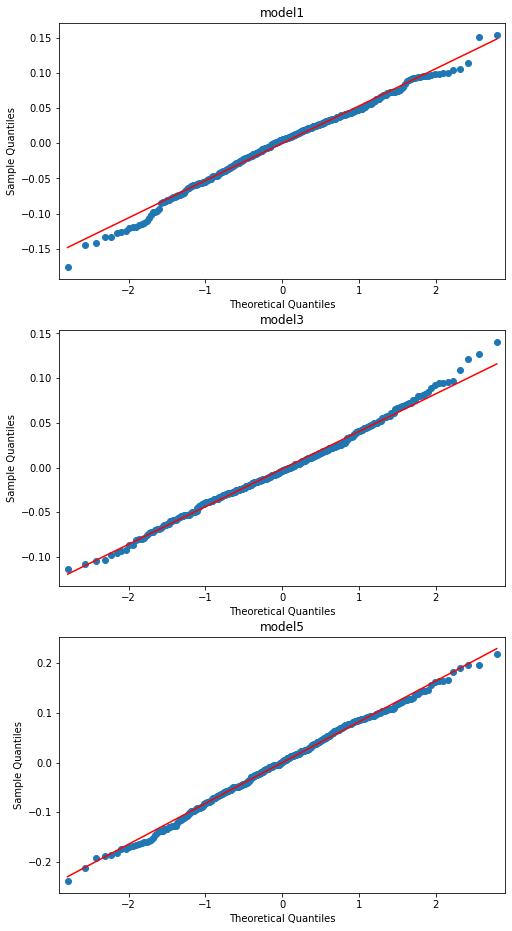

In [87]:
#잔차의 정규성 확인
fig = plt.figure(figsize=(8,16))
#model1
ax1 = fig.add_subplot(311)
fig = qqplot(model1_fit.resid, line='s', ax=ax1)
plt.title('model1')
#model3
ax2 = fig.add_subplot(312)
fig = qqplot(model3_fit.resid, line='s', ax=ax2)
plt.title('model3')
#model5
ax3 = fig.add_subplot(313)
fig = qqplot(model5_fit.resid, line='s', ax=ax3)
plt.title('model5')

* 잔차의 정규성을 확인해본 결과 model1 에 비하여 model3,5가 빨간 일직선 위에 점들이 더 잘 분포하는 것으로 보인다. 따라서 잔차의 정규성은 model3과 model5가 더 만족한다고 볼 수 있다.

* 종합해본 결과 model1과 model5에 비하여 model3이 가장 적합한 모델임을 알 수 있었으며, 따라서 최종 모형을ARIMA(2,1,2)로 선정하였다.

#### **최종모형: ARIMA(2,1,2)**

## 3. 예측

In [88]:
result = model3_fit.get_forecast(steps = len(test_data.index), alpha = 0.05).summary_frame()
result

Electric_Production,mean,mean_se,mean_ci_lower,mean_ci_upper
2017-02-01,-0.085799,0.041282,-0.166711,-0.004888
2017-03-01,-0.096192,0.041283,-0.177105,-0.015279
2017-04-01,-0.018550,0.053694,-0.123789,0.086689
2017-05-01,0.063424,0.062784,-0.059631,0.186479
2017-06-01,0.075523,0.062809,-0.047581,0.198626
2017-07-01,0.018066,0.067885,-0.114986,0.151118
2017-08-01,-0.046298,0.072645,-0.188680,0.096084
2017-09-01,-0.058745,0.072701,-0.201236,0.083746
2017-10-01,-0.016411,0.075133,-0.163669,0.130847
2017-11-01,0.033981,0.077799,-0.118503,0.186465


* 테스트 데이터의 개수만큼 예측값을 뽑아보았다.

In [105]:
fc = tuple(result['mean'].values) # 예측값
se = tuple(result['mean_se'].values) # 표준오차
mean_ci_lower = tuple(result['mean_ci_lower'].values) # 신뢰구간의 최소
mean_ci_upper = tuple(result['mean_ci_upper'].values) # 신뢰구간의 최대

# 예측값을 인덱스 넣기
fc_data = pd.Series(fc, index = test_data.index)

# 신뢰구간을 인덱스 넣기
lower_data = pd.Series(mean_ci_lower, index = test_data.index)
upper_data = pd.Series(mean_ci_upper, index = test_data.index )

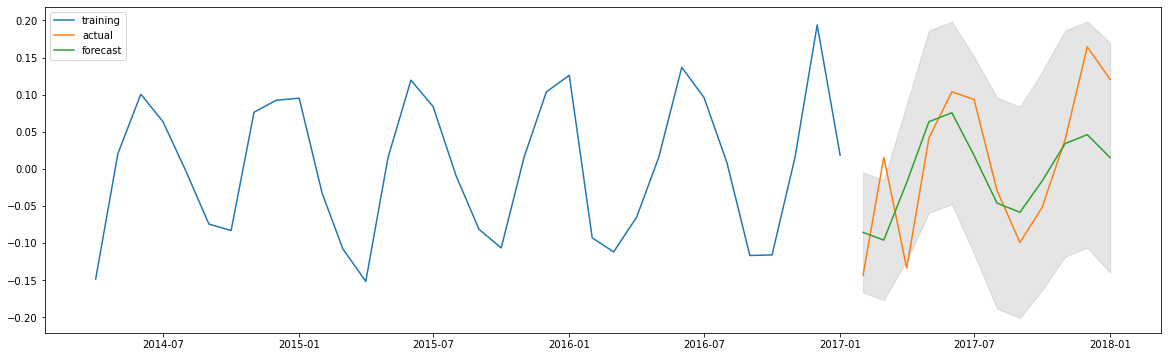

In [106]:
plt.figure(figsize =(20, 6))
plt.plot(train_data[350:], label = 'training')
plt.plot(test_data, label = 'actual')
plt.plot(fc_data, label = 'forecast')
plt.fill_between(test_data.index, lower_data, upper_data, color = 'black', alpha = 0.1)
plt.legend(loc = 'upper left')
plt.show()

* 예측값을 그래프로 그려본 결과 실제값을 정확히 예측해내지 못한 것을 알 수 있다. 어느정도 모양을 따라가긴 하지만 정확하다고 볼 수는 없다. 

## 추가
### Auto arima

In [107]:
model = pm.auto_arima(y = train_data        
                      , d = 1            # 차분 차수 
                      , m = 1       
                      , seasonal = False 
                      , stepwise = True
                      , trace=True
                      )

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-732.160, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-742.376, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-755.344, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-734.160, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.56 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.66 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-757.343, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.44 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-744.376, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.54 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 4.506 seconds


* auto_arima를 사용한 결과 최적의 모델은 ARIMA (0,1,1) 모형으로 나왔다.

In [109]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  384
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 380.672
Date:                Mon, 22 Aug 2022   AIC                           -757.343
Time:                        17:28:12   BIC                           -749.447
Sample:                    02-01-1985   HQIC                          -754.211
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3027      0.050      6.104      0.000       0.206       0.400
sigma2         0.0080      0.001     11.284      0.000       0.007       0.009
Ljung-Box (L1) (Q):                   0.52   Jarque-

* Ljung-Box (Q), Heteroskedasticity (H), Jarque-Bera (JB)은 모두 잔차에 대한 검정 통계량이다. 

* 여기서 Ljung-Box (Q)은 잔차가 백색잡음인지 검정한 통계량이며, Prob (Q) 값이 0.47이므로 유의수준 0.05에서 귀무가설을 기각하지 못한다. 여기서 Ljung-Box (Q) 통계량의 귀무가설은 “잔차가 백색잡음 시계열을 따른다”이므로, 위 결과를 통해 시계열 모형이 잘 적합되었고 남은 잔차는 더이상 자기상관을 가지지 않는 백색 잡음임을 확인할 수 있다.

* Jarque-Bera (JB) 자크-베라 검정 통계량은 잔차가 정규성을 띠는지 검정한 통계량이다. Prob(JB)값을 보면 0.03으로 유의 수준 0.05에서 귀무가설을 기각한다. Jarque-Bera (JB) 통계량의 귀무가설은 “잔차가 정규성을 만족한다”이므로, 위 결과를 통해 잔차가 정규성을 따르지 않음을 확인할 수 있다.

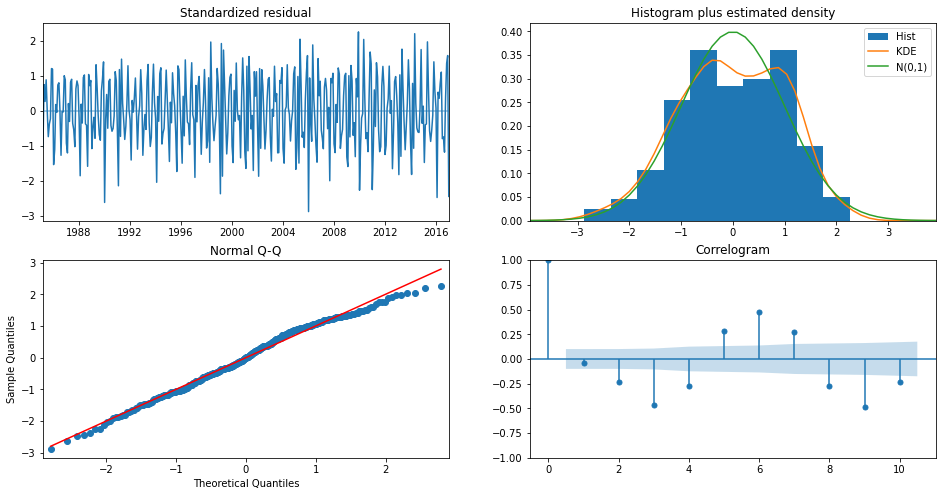

In [110]:
model.plot_diagnostics(figsize=(16, 8))
plt.show()

* auto arima 를 진행하며 알게되었지만, `plot_diagnostics`를 통해서 잔차를 시각화할 수 있다.  


* 여기서 잔차가 백색 잡을 따르는지 보여주는 그래프는 Standardized residual과 Correlogram 이다.
    - Standardized residual는 잔차를 시계열로 그린 것이며, 평균 0을 중심으로 무작위하게 움직이는 것을 파악할 수 있다.
    * Correlogram은 잔차에 대한 ACF이며, 허용 범위에 조금 벗어난 것을 알 수 있다.  
    
    
* 여기서 잔차가 정규성을 만족하는지 보여주는 그래프는 Histogram plus estimated density와 Normal Q-Q 이다.
    - Histogram plus estimated density는 잔차의 히스토그램을 그려 정규 분포 N(0,1)와 밀도를 추정한 그래프를 같이 겹쳐서 보여준다.  정규분포와 비슷하게 대칭적이지만, 정규분포를 완벽히 따르지는 않는 것을 알 수 있다.
    - Normal Q-Q그래프는 Q-Q 그래프로 정규성을 만족한다면 빨간 일직선 위에 점들이 분포해야 한다. 하지만, 양 끝에서 빨간 선을 약간 벗어난 것을 알 수 있다.

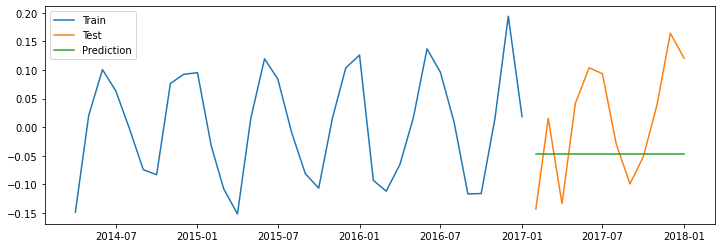

In [112]:
predict = model.predict(n_periods=len(test_data)) 
predict = pd.DataFrame(predict,index = test_data.index,columns=['Prediction'])

# 그래프
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(train_data[350:], label='Train')        # train 데이터
plt.plot(test_data, label='Test')          # test 데이터
plt.plot(predict, label='Prediction')  # 예측 
plt.legend()
plt.show()

* 예측 결과를 시각화 해보았을 때 실제 데이터와 다르게 예측값은 일직선으로 예측이 된 것을 알 수 있다.